CQF Final project

"We need to test if time-series are weakly stationary, or integrated of order zero (I(0)), if its statistical properties—specifically its mean, variance, and autocovariance—are invariant with respect to time. The majority of financial price series do not exhibit this property; they are typically non-stationary and contain a unit root, meaning they are integrated of order one (I(1)). A critical issue arises when standard regression techniques are applied to I(1) series. Regressing one I(1) series on another can lead to a "spurious regression," a situation where high R-squared values and statistically significant coefficients are observed even when no genuine economic relationship exists between the variables. This necessitates formal testing for stationarity."

The augmented Dickey–Fuller specification is:

$$
\Delta y_t = \alpha + \beta\,t + \gamma\,y_{t-1}
        + \sum_{i=1}^{p} \delta_i\,\Delta y_{t-i} + \varepsilon_t
$$

The hypotheses are:

- Null hypothesis: $H_0: \gamma = 0$
  (implying a unit root; the series is non-stationary)

- Alternative hypothesis: $H_1: \gamma < 0$
  (implying stationarity)


The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test statistic for trend‐stationarity is given by

$$
\mathrm{KPSS} \;=\;
\frac{1}{T^2} \sum_{t=1}^T S_t^2 \;\bigg/\; \widehat{\sigma}^2
$$

where

$S_t = \sum_{i=1}^t \widehat{u}_i$

$\widehat{u}_i = y_i - \widehat{\beta}_0 - \widehat{\beta}_1\,i$
are the residuals from the OLS regression of \(y_t\) on an intercept and time trend.  
$(\widehat{\sigma}^2\)$ is a consistent estimate of the long‐run variance of $(\widehat{u}_t\)$, often computed via a Newey–West estimator:
  $$
  \widehat{\sigma}^2
  = \frac{1}{T}\sum_{t=1}^T \widehat{u}_t^2
    \;+\; 2 \sum_{\ell=1}^L w\bigl(\ell,L\bigr)\,
    \frac{1}{T}\sum_{t=\ell+1}^T \widehat{u}_t\,\widehat{u}_{t-\ell},
  $$
  with Bartlett weights \(w(\ell,L)=1-\ell/(L+1)\).

The hypotheses reverse those of the ADF:

- **Null hypothesis** (stationarity around a deterministic trend):  
  $$H_0:\; \{y_t\}\text{ is trend‐stationary}$$

- **Alternative hypothesis** (presence of a unit root):  
  $$H_1:\; \{y_t\}\text{ has a unit root (non‐stationary)}$$

**Interpretation:**  
- A large KPSS statistic leads to rejection of \(H_0\), suggesting non‐stationarity.  
- Used alongside the ADF:  
  - **Fail to reject ADF null** (evidence of unit root) **and** **reject KPSS null** (evidence against stationarity) ⇒ strong confirmation that \(y_t\) is \(I(1)\).


## Statistical Analysis and Threshold Optimization

This section performs the statistical tests and threshold optimization for the downloaded asset groups.

In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from data_download import fetch_asset_data
from coint_tests import engle_granger, ou_params, summarize_cointegration_tests, run_pair_backtests, matrix_ols_regression, select_var_order
from pair_selection_summary import assemble_group_summary
from backtest import nested_cv, generate_signals, generate_pair_pnl
from plotting import plot_performance, analyze_pairs_nb


pd.set_option('display.float_format', '{:.2f}'.format)

**Pairs Selection Rationale**

For this analysis, I have taken a qualitative approach to selecting a diverse range of asset pairs and triples that are likely to exhibit cointegration based on economic relationships, quantitative characteristics, and event-driven factors. The chosen groups span commodities, fixed income, currencies, volatility products, country indices, equities, and sector ETFs. Each group is motivated by plausible market linkages e.g. shared fundamentals, regulatory, macroeconomic ties, or structural features. The goal is to test these candidates empirically for meaningful cointegration, and then focus further analysis on the top contenders that demonstrate robust statistical relationships. I have included a couple of tripples to also run Johansen tests, but most cases are pairs.

**Pair/Triple Summaries**

- **Precious Metals Triple (Gold, Silver, Platinum):** These metals often move together due to their roles as stores of value and industrial inputs, with cointegration potentially driven by macroeconomic cycles and investor sentiment.
- **Oil Pair (WTI, Brent):** WTI and Brent oil are global crude benchmarks whose price relationship reflects supply-demand dynamics, geopolitical events, and infrastructure changes.
- **Agri Pair (Corn, Soybean):** Corn and soybean prices are linked by crop rotation, weather patterns, and global trade flows, making them natural candidates for cointegration.
- **Yield Pair (US 10Y Yield, UK Gilts ETF):** US and UK government bond yields are influenced by global interest rate cycles and monetary policy, often showing correlated movements.
- **Currency Pair (AUD/USD, CAD/USD):** Both AUD and CAD are commodity-linked currencies, with their exchange rates shaped by similar macroeconomic and trade factors.
- **Volatility Pair (VIX, VIXY):** The VIX index and VIXY ETF track US equity volatility, with their relationship affected by futures curve dynamics and market stress regimes.
- **EU Index Pair 1 (CAC 40, DAX):** French and German equity indices are closely tied through European economic integration and cross-border corporate activity.
- **EU Index Pair 2 (IBEX 35, FTSE MIB):** Spanish and Italian indices reflect Southern European market conditions, often responding similarly to regional events.
- **FR Banking Pair (BNP Paribas, Societe Generale):** Two major French banks with overlapping business models and exposure to the same regulatory environment.
- **Fast Fashion Pair (Inditex, H&M):** Leading European fast fashion retailers, whose performance is shaped by consumer trends and global supply chains.
- **German Auto Triple (VW, Mercedes, BMW):** Germany’s top automakers, sharing industry cycles, regulatory changes, and technological shifts.
- **Investor AB Pair (Investor A, Investor B):** Two share classes of the same Swedish investment company, expected to track closely due to identical underlying assets but with different voting rights.
- **VW Porsche Pair (VW, Porsche AG):** Linked through ownership structure and shared automotive sector exposure.
- **Semiconductor Pair (ASML, Infineon):** European semiconductor firms, with cointegration possible due to sector wide demand and supply chain factors.
- **Sector ETF Pair (XLRE, XLU):** US real estate and utilities ETFs, both considered defensive sectors and often moving together during risk-off periods.


In [2]:
end_date   = datetime.now()
start_date = end_date - timedelta(days=5*365)

asset_groups = {
    # Commodities
    "precious_metals_triple": ["GC=F", "SI=F", "PL=F"],    # Gold, Silver, Platinum Futures
    "oil_pair": ["CL=F", "BZ=F"],                          # WTI, Brent Crude Futures
    "agri_pair": ["ZC=F", "ZS=F"],                         # Corn, Soybean Futures

    # Fixed Income & Currency
    "yield_pair": ["^TNX", "IGLT.L"],                      # US 10Y Yield, iShares UK Gilts ETF
    "currency_pair": ["AUDUSD=X", "CADUSD=X"],             # AUD/USD, CAD/USD

    # Volatility
    "volatility_pair": ["^VIX", "VIXY"],                   # US VIX Index vs. Short-Term VIX Futures ETF*

    # Country Indices
    "eu_index_pair_1": ["^FCHI", "^GDAXI"],                # CAC 40, DAX
    "eu_index_pair_2": ["^IBEX", "FTSEMIB.MI"],            # IBEX 35, FTSE MIB

    # Equities
    "fr_banking_pair": ["BNP.PA", "GLE.PA"],               # BNP Paribas, Societe Generale
    "fast_fashion_pair": ["ITX.MC", "HM-B.ST"],            # Inditex, H&M
    "german_auto_triple": ["VOW3.DE", "MBG.DE", "BMW.DE"], # VW, Mercedes, BMW
    "investor_ab_pair": ["INVE-A.ST", "INVE-B.ST"],        # Investor A, Investor B
    "vw_porsche_pair": ["VOW3.DE", "P911.DE"],             # VW, Porsche AG
    "semiconductor_pair": ["ASML.AS", "IFX.DE"],           # ASML, Infineon

    # ETFs
    "sector_etf_pair": ["XLRE", "XLU"]                     # Real Estate ETF, Utilities ETF
}

all_data = fetch_asset_data(asset_groups, start_date, end_date)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%********

**Data Exploration and Regression/VAR Diagnostics**

After downloading the series we can inspect the data and run simple regressions and VAR order selection.

In [3]:
import statsmodels.api as sm
reg_var_summary = []
for name, df in all_data.items():
    y = df.iloc[:,0]
    X = sm.add_constant(df.iloc[:,1:])
    beta = matrix_ols_regression(y.values, X.values)
    preds = X.values @ beta
    r2 = 1 - ((y.values - preds)**2).sum() / ((y.values - y.mean())**2).sum()

    var_df, best_aic, best_bic, best_hqic = select_var_order(df.dropna())
    eigvals = var_df.loc[var_df['lag']==best_aic, 'eigenvalues'].iloc[0]
    eigvals_magnitude = [np.abs(x) for x in eigvals]
    eigvals_str = ' '.join([f'{abs(x):.3f}' for x in eigvals_magnitude])

    reg_var_summary.append({
        'group': name,
        'r_squared': r2,
        'best_aic': best_aic,
        'best_bic': best_bic,
        'best_hqic': best_hqic,
        'eigenvalues': eigvals_str
    })
reg_var_summary = pd.DataFrame(reg_var_summary)
reg_var_summary


,group,r_squared,best_aic,best_bic,best_hqic,eigenvalues
0,precious_metals_triple,0.84,10,1,1,10.686 2.052 2.052 1.588 1.588 1.429 1.429 1.4...
1,oil_pair,0.99,9,2,2,1.536 1.536 1.442 1.442 1.412 1.412 1.346 1.34...
2,agri_pair,0.81,1,1,1,1.019 1.004
3,yield_pair,0.93,3,2,2,5.367 3.645 3.645 3.598 1.008 1.003
4,currency_pair,0.83,5,1,2,2.391 2.391 2.236 2.236 2.157 2.157 1.880 1.88...
5,volatility_pair,0.22,8,2,3,1.748 1.658 1.658 1.658 1.658 1.517 1.517 1.49...
6,eu_index_pair_1,0.60,1,1,1,1.006 0.998
7,eu_index_pair_2,0.95,1,1,1,1.011 1.000
8,fr_banking_pair,0.77,1,1,1,1.004 0.996
9,fast_fashion_pair,0.25,1,1,1,1.011 1.001


**Cointegration Testing Approach**

With our asset pairs and triples selected, the next step is to rigorously test for cointegration and related statistical properties across all groups. To do this, we employ a suite of econometric tests for  time-series analysis and pairs trading research. For each asset group, we run both univariate and multivariate tests to assess stationarity, cointegration, and the dynamics of the spread.

Specifically, we use the following methods:


- **Univariate Stationarity Tests:**  
  Each individual time series is tested for stationarity using the Augmented Dickey-Fuller (ADF) and KPSS tests.

A time series $X_t$ can be regarded as stationary (in the weak sense) if properties like mean, variance, and autocorrelation structure are constant over time. Stationarity is a good thing for mean-reversion strategies such as the ones we are about to implement because if a series’ distribution shifts over time (non-stationarity), it becomes hard to predict or rely on past behavior since the behavior drifts. Financial price series are typically non-stationary often exhibiting trends or unit roots (random walk behavior). A unit root process is one that must be differenced to achieve stationarity (we say it is integrated of order 1, or $I(1)$, if one difference yields stationarity; stationary series are $I(0)$ by definition). To diagnose stationarity vs. unit roots I will use the Augmented Dickey–Fuller (ADF) test checks for a unit root with the null hypothesis $H_0$: “series has a unit root (non-stationary)” against the alternative $H_1$: “stationary”. The ADF test is based on estimating a regression of the form:

$$\Delta X_t = \gamma\,X_{t-1} + \sum_{i=1}^{p} \phi_i\,\Delta X_{t-i} + \varepsilon_t$$

where $\Delta X_t = X_t - X_{t-1}$ is the first difference of the series, and lagged difference terms $\Delta X_{t-i}$ are included (up to some lag $p$) to account for any autocorrelation in the residuals. $\gamma$ measures the tendency of $X_{t-1}$ to pull $X_t$ back towards zero. If $X_t$ has a unit root  then  $\gamma = 0$ (no corrective pull back implying $\Delta X_t$ is just noise and past level has no effect). If $X_t$ is stationary, we expect $\gamma < 0$ (a negative coefficient drives $\Delta X_t$ in the opposite direction of $X_{t-1}$, damping shocks and confining the series). The ADF test computes a $t$-statistic for $\hat{\gamma}$; if $\gamma$ is significantly negative (the $t$-statistic is below a critical value from the Dickey–Fuller distribution), we reject $H_0$ and conclude the series is stationary. Otherwise, we fail to reject the presence of a unit root.

For KPSS test (Kwiatkowski–Phillips–Schmidt–Shin) we take the opposite approach, the null hypothesis is that the series is stationary, and the alternative is that the series has a unit root. KPSS test statistic is constructed by looking at the series residuals from a trend and checking for the presence of a random-walk component. If ADF rejects $H_0$ (suggesting stationarity) while KPSS fails to reject its $H_0$ (also consistent with stationarity) we have 2 indicators of stationarity. If one test  reject and the other not it could indicate e.g. trend-stationarity (the series is stationary after removing a deterministic trend) or simply that the evidence is mixed. In those cases, further scrutiny may be needed.

ADF and KPSS are implemented using statsmodels.tsa.stattools, below code collects the results of these tests into dictionaries that can be used for aggregating and analyzing the results later on:

In [4]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_results(series):
    """Returns ADF test outputs."""
    stat, pval, _, _, crit, _ = adfuller(series.dropna(), autolag='AIC')
    return {
        'stat': stat,
        'pvalue': pval,
        **{f'crit_{k}': v for k, v in crit.items()}
    }


def kpss_results(series):
    """Returns KPSS test outputs."""
    stat, pval, _, crit = kpss(series.dropna(), regression='c', nlags='auto')
    return {
        'stat': stat,
        'pvalue': pval,
        **{f'crit_{k}': v for k, v in crit.items()}
    }

- **Engle-Granger Cointegration Test:**  
  For pairs I apply the Engle-Granger two-step method to check if a linear combination of the two series is stationary which indicates cointegration.

The previous discussed ADF and KPSS tests were univariate tests, the idea behind cointegration is to see if see if we can get a desired stationary series by differencing 2 (or more if we take a portfolio approach) assets. Let $Y_t$ and $X_t$ be two price series that are each $I(1)$ (non stationary). If there exists some coefficient $\beta$ such that the spread (or residual):

$$u_t = Y_t - \beta\,X_t$$

is $I(0)$ (stationary) then $Y_t$ and $X_t$ are cointegrated. Cointegration means that $Y$ and $X$ share a  stochastic trend, they move together in the long run even though each by itself follow a random walk. The spread $u_t$ represents the short-term deviation from the equilibrium $Y_t \approx \beta X_t$.If  $u_t$ is mean reverting it implies that whenever $Y$ and $X$ drift too far apart economic forces (or arbitrage) tend to pull them back. To test for cointegration in the pairs series I will use the Engle–Granger two-step method:

1. Estimate the Cointegrating Relationship: Perform a linear regression of $Y_t$ on $X_t$ to find the best-fit relation: $Y_t = c + \beta\,X_t + u_t $ using OLSs, obtaining estimates $\hat{c}$ and $\hat{\beta}$. $u_t$ is our estimated spread. hedge ratio $\beta$ functions as our hedge ratio.
2. Test the Residual for Stationarity: We then apply ADF to test for stationarity on the residual $\hat{u}_t$. If the residual is stationary we can say that the pair $Y_t$ and $X_t$ is cointegrated.

A caveat is that this method treats one series as dependent and the other as independent. If $Y_t$ and $X_t$ are cointegrated it shouldn’t matter which one is $Y$ and $X$. But in finite samples, the regression results can differ depending on which variable is on the left side. This is the dependent variable problem. Also Engle–Granger can only find at most one cointegrating relationship which is fine for our pairs but we need something different for the triples which leads us to the next section.

The Engle-Granger test is implemented using statmodels OLS:

In [5]:
import statsmodels.api as sm

def engle_granger(df, y, x):
    """Returns hedge ratio and ADF p-value on residuals, plus spread if cointegrated."""
    x0 = sm.add_constant(df[x])
    model = sm.OLS(df[y], x0).fit()
    beta = model.params[x]
    spread = df[y] - beta * df[x]
    pval = adfuller(spread.dropna(), maxlag=1, autolag=None)[1]
    return {'beta': beta, 'eg_pvalue': pval, 'spread': spread if pval <= .05 else None}

- **Johansen Test:**  
  For triples, the Johansen procedure is used to detect cointegration relationships among three assets simultaneously.

The Johansen test starts from a Vector Autoregression (VAR) model with $n$ time series and then imposes structures to detect cointegration. If cointegration exists, there is an underlying error-correcting in the level variables. For $n$ time series in vector form  $\mathbf{Y}t = [Y{1,t}, Y_{2,t}, \dots, Y_{n,t}]^\top$, the error-correction form (VECM) is:

$$\Delta \mathbf{Y}_t = \Pi\, \mathbf{Y}_{t-1} \;+\; \sum_{i=1}^{p-1} \Gamma_i\,\Delta \mathbf{Y}_{t-i} \;+\; \mathbf{D}_t \;+\; \varepsilon_t~$$

where $\Delta \mathbf{Y}_t = \mathbf{Y}t - \mathbf{Y}{t-1}$ is the vector of first differences. $\mathbf{D}_t$ represents a constant/trend) and $\varepsilon_t$ is the error terms. Object $\Pi$ is an $n \times n$ coefficient matrix that captures the long-run relationships. The short-run dynamics are captured by the $\Gamma_i$ matrices for $i=1,\dots,p-1$ (these are $n \times n$ matrices multiplying the lagged differences). The rank of $\Pi$, denoted $r = \mathrm{rank}(\Pi)$ shows the number of cointegrating relationships.
If $r = 0$, then $\Pi$ is a zero matrix (no long-run equilibrium term) the VECM reduces to a pure differenced VAR implying no cointegration.
If $r = n$, then $\Pi$ is full rank meaning all linear combinations of $\mathbf{Y}_t$ are stationary.
If $0 < r < n$, there are $r$ independent cointegrating vectors. In this case, we can factor $\Pi$ as $\Pi = \alpha\,\beta^\top $ where $\beta$ is an $n \times r$ matrix whose columns are $r$ distinct cointegrating vectors, and $\alpha$ is an $n \times r$ matrix of coefficients that represent the speed of adjustment for each cointegrating relationship in each equation of the system. The matrix product $\Pi \mathbf{Y}{t-1} = \alpha (\beta^\top \mathbf{Y}{t-1})$ then has dimension $n \times 1$ and effectively inserts up to $r$ error-correction terms  in $\Delta \mathbf{Y}t$. Each term $\beta^\top \mathbf{Y}{t-1}$ is the equilibrium error (the extent to which the long-run relation was out of balance at $t-1$), $\alpha$ is the strength of the relation to the error in the next time step.

Johansens test provides two likliehood ratio tests, trace test and maximum eigenvalue.The ratios derive from the eigenvalues of a matrix related to $\Pi$. $\hat{\lambda}_1 \ge \hat{\lambda}_2 \ge \cdots \ge \hat{\lambda}_n$ are the sorted eigenvalues obtained from Johansens test, these $\hat{\lambda}_i$ measure the strength of the cointegrating relations.

Trace Test: The trace statistic for testing $H_0$: “at most $r$ cointegrating vectors” (i.e. $r$ or fewer) against the alternative $H_1$: “more than $r$ cointegrating vectors” is $\Lambda_{\text{trace}}(r) = -\,T \sum_{i=r+1}^{n} \ln(1 - \hat{\lambda}_i) $ for $T$ observations. Under $H_0$, the $r+1$ through $n$ eigenvalues should be zero so this statistic will be low. If there is an additional cointegration beyond $r$, some $\hat{\lambda}{r+1}$ will be appreciable and make the statistic large. We start with $H_0: r=0$ (no cointegration) and compute $\Lambda{\text{trace}}(0)$. If this exceeds the critical value, we reject $H_0$ and infer at least one cointegrating vector exists. Then we test $H_0: r = 1$ versus $r > 1$, and so on increasing $r$ until we fail to reject. Essentially the trace test examines the smaller eigenvalues collectively beyond the $r$th.

Max Eigenvalue Test: The maximum eigenvalue test focuses on one eigenvalue at a time. It tests $H_0$: “exactly $r$ cointegrating vectors” against $H_1$: “exactly $r+1$ cointegrating vectors” by looking at the $(r+1)$-th eigenvalue. The statistic is $\Lambda_{\max}(r) = -\,T \ln(1 - \hat{\lambda}_{r+1})$ Starting from $r=0$ versus $r=1$, if $\Lambda_{\max}(0)$ is above its critical threshold, we reject and conclude at least one cointegrating relation; otherwise none. Then test $r=1$ vs $2$, etc., similarly to the trace procedure but focusing on the next eigenvalue at each step.

Johansen’s test has the advantage of detecting multiple cointegrating relationships. It treats all variables symmetrically unlike Engle–Granger. However, Johansen’s is sensitive to the lag length $p$ for the underlying VAR.

For the Johansen test i use the statsmodels.tsa.vector_ar.vecm implementation, below function applies the model and collects the results:

In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def johansen(df):
    """Returns number of coint relationships and eigenvector for first."""
    res = coint_johansen(df.dropna(), det_order=0, k_ar_diff=1)
    n = np.sum(res.lr1 > res.cvt[:, 1])
    vec = res.evec[:, 0]
    return {'johansen_n': int(n), **{f'eig_{i}': v for i, v in enumerate(vec)}}

- **Error Correction Model (ECM):**  
  We estimate ECM parameters to understand how deviations from equilibrium are corrected over time.

If two series $Y_t$ and $X_t$ are cointegrated they share a long-run equilibrium and any short-run deviations from that equilibrium influence future changes. This is captured by an Error-Correction Model (ECM). Let $u_{t-1} = Y_{t-1} - \beta X_{t-1}$ be the equilibrium error from the previous period ($\beta$ and intercept $c$ esimated from previous steps). The ECM for the pair is then:

$$\Delta Y_t = \alpha\,u_{t-1} \;+\; \sum_{i=1}^{p-1} \phi_i\,\Delta Y_{t-i} \;+\; \sum_{i=1}^{p-1} \psi_i\,\Delta X_{t-i} \;+\; \eta_t$$

$\Delta Y_t$ and $\Delta X_t$ represent short-term changes and $u_{t-1}$ is the lagged cointegration residual. The $\alpha$ is the speed of adjustment for $Y_t$, if $\alpha$ is negative, it means that if $Y$ was higher than $\beta X$ last period (making $u_{t-1} > 0$), then $\Delta Y_t$ will tend to be negative so $Y$ will fall to correct the divergence (and $X$ might rise in its equation if its coefficient is positive). This mechanism ensures the two series close the gap when they deviate. If $\alpha=0$, $Y$ does not adjust ( all adjustment could happen through $X$’). ECM is a discrete time analog of a mean reverting system. 

From a trading strategy perspective we take our cointegrated pair and form the spread $S_t = Y_t - \beta X_t$ rhe spread as an independent mean reverting series. ECM estimate its mean-reversion speedwhich can guide our strategy (e.g., how long we expect deviations to last).

Below implementation takes x, y, and the spread as inputs to then output the ECM error coefficient and corresponding p value:

In [7]:
def analyze_error_correction_model(y, x, spread):
    """
    Error-Correction Model (ECM) returns the coefficient and p-value of the error term.
    """
    ec_term = spread.shift(1).dropna() # lag spread by 1 period
    delta_y, delta_x = y.diff().dropna(), x.diff().dropna() # difference to original
    aligned_data = pd.concat([delta_y, delta_x, ec_term], axis=1).dropna() # Align all series to the same index
    aligned_data.columns = ['delta_y', 'delta_x', 'ec_term']
    X_ecm = sm.add_constant(aligned_data[['delta_x', 'ec_term']]) # regress on error term
    y_ecm = aligned_data['delta_y']
    model = sm.OLS(y_ecm, X_ecm).fit()
    ec_coeff = model.params['ec_term'] # extract results
    ec_pvalue = model.pvalues['ec_term']
    
    return {'ecm_coeff': ec_coeff, 'ecm_pvalue': ec_pvalue}

- **Ornstein-Uhlenbeck (OU) Process Fitting:**  
  If cointegration is found, we fit an OU process to the spread to characterize its mean-reverting behavior.



With the spread $S_t = Y_t - \beta X_t$ in place coupled with the fact that if $Y$ and $X$ are cointegrated $S_t$ should behave like a mean reverting series. The Ornstein–Uhlenbeck (OU) stochastic differential equation is a continuous time model for that behavior. Assuming $S_t$ follows an OU process:

$$dS_t = \theta\,(\mu - S_t)\,dt \;+\; \sigma\,dW_t~$$

$\mu$ is the long-run mean level of the spread, $\theta > 0$ is the mean-reversion speed, $\sigma$ is the volatility and $dW_t$ is the incremental Wiener process. The SDE says the drift of $S_t$ is $\theta(\mu - S_t)$. If $S_t$ is above $\mu$ the drift is negative. The random term $\sigma,dW_t$ adds fluctuations with volatility $\sigma$. The OU process the analytical properties of solution and discrete equivalence: The OU process is the continuous-time analogue of a discrete-time AR(1) mean-reverting process. For daily data ($\Delta t = 1$ day), this suggests we can model the spread with an AR(1) regression: $S_{t+1} = \mu_e + \rho\,(S_t - \mu_e) + \varepsilon_t $ where $\mu_e$ is the sample mean spread and $\rho$ is the lag-1 autocorrelation. $\rho = e^{-\theta,\Delta t}$. E.g. if $\Delta t = 1$, then $\rho \approx e^{-\theta}$. We can estimate $\hat{\rho}$ from historical spread data and invert this tto find the continuous-time parameter  $\hat{\theta} = -\ln(\hat{\rho})$ (assuming $\hat{\rho}<1$ as required for stationarity). This is how we calibrate $\theta$ from discrete data. For instance, if we find $\hat{\rho} = 0.95$ (the spread has a 95% persistence day-over-day), then $\hat{\theta} = -\ln(0.95) \approx 0.0513$. The time it takes for a deviation to decay by 50% is given by $T_{1/2} = \frac{\ln(2)}{\theta} $. In this example, $T_{1/2} \approx 0.693/0.0513 \approx 13.5$ days. A shorter half-life means allows for more trades. OU is a Gauss-Markov process, for $\theta>0$ it has a stationary distribution. In steady state the pull and random movement balance us meaning as $t \to \infty $ $ S_t$ is normally distributed with mean $\mu$ and variance $\displaystyle \frac{\sigma^2}{2,\theta}$. The fact that the spread is approx normal means we can design entry/exit rules based on standard deviations.

The OU model provides a theoretical justification for using standard deviation bands on the spread. We can estimate $\mu$, $\sigma$ and $\theta$ from historical data. Then if e.g. $S_t$ is 2 standard deviations above $\mu$ should be a relatively rare event given $S_t$ is stationary normal, suggesting a good shorting opportunity.

To implement the OU we input the spread and from that we can calculate the mu, theta, half-life and sigma:

In [8]:
def ou_params(spread):
    """Returns OU mu, theta, and half-life."""
    dS = spread.diff().dropna()
    S1 = spread.shift(1).dropna()
    df = pd.concat([dS, S1], axis=1).dropna()
    df.columns = ['dS', 'S1']
    model = sm.OLS(df['dS'], sm.add_constant(df['S1'])).fit()
    theta = -model.params['S1']
    mu = model.params['const'] / theta
    hl = np.log(2) / theta
    sigma_eq = spread.std()
    return {'ou_mu': mu, 'ou_theta': theta, 'ou_halflife': hl, 'ou_sigma': sigma_eq}

- **Kalman Filter Hedge Ratio:**  
  Dynamic hedge ratios are estimated using a Kalman filter for further robustness.

In [9]:
from pykalman import KalmanFilter

def kalman_hedge(df, y, x):
    """Returns dynamic beta and spread series."""
    yv, xv = df[y].values, df[x].values
    kf = KalmanFilter(
        n_dim_obs=1, n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.eye(2),
        observation_matrices=np.vstack([xv, np.ones_like(xv)]).T[:, None, :],
        transition_matrices=np.eye(2),
        transition_covariance=1e-4 * np.eye(2)
    )
    state_means, _ = kf.filter(yv)
    beta = pd.Series(state_means[:, 0], index=df.index, name='kf_beta')
    alpha = pd.Series(state_means[:, 1], index=df.index, name='kf_alpha')
    spread = df[y] - beta * df[x] - alpha
    return {'kf_beta': beta, 'kf_spread': spread}

This produces a comprehensive DataFrame of test statistics and model parameters for each group, allowing us to identify which pairs/triples exhibit meaningful cointegration and are suitable for further analysis and strategy development.

In [10]:
summary_df = summarize_cointegration_tests(all_data)
summary = assemble_group_summary(all_data)

summary

,group,n_assets,eg_pvalue,joh_n_relations,ou_halflife,ou_sigma,sharpe_spread,beta_stability,ecm_pvalue,Z_star,N_trades_Zstar,avg_PnL_Zstar
0,precious_metals_triple,3,NaN,0.00,26.44,1.49,1.12,NaN,NaN,2.40,4.00,7.87
1,oil_pair,2,0.00,NaN,8.55,1.46,1.32,0.02,0.00,0.50,41.00,1.75
2,agri_pair,2,0.01,NaN,38.46,52.27,-1.89,0.10,0.00,1.40,10.00,93.45
3,yield_pair,2,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,currency_pair,2,0.02,NaN,38.99,0.02,-15.05,0.06,0.00,1.20,9.00,0.02
5,volatility_pair,2,0.00,NaN,45.71,374.18,-0.95,3.65,0.00,0.80,4.00,612.94
6,eu_index_pair_1,2,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,eu_index_pair_2,2,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,fr_banking_pair,2,0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,fast_fashion_pair,2,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The three pairs selected for further analysis—**oil_pair**, **currency_pair**, and **volatility_pair**—were chosen based on a combination of statistical and practical criteria from the results table. Specifically, these pairs exhibited:

- **Strong evidence of cointegration:** All three have very low Engle-Granger p-values (eg_pvalue ≈ 0.00–0.03), indicating rejection of the null hypothesis of no cointegration.
- **Model stability and interpretability:** Each pair has meaningful Ornstein-Uhlenbeck (OU) process parameters (halflife, sigma), and the spread statistics are well-defined.
- **Sufficient trading opportunities:** The number of trades at the optimal Z threshold (N_trades_Zstar) is reasonable, suggesting the strategy is actionable.
- **Interesting economic rationale:** These pairs represent diverse asset classes (commodities, currencies, volatility), making them attractive for further strategy development.

Other results of note:

- **Agri Pair:** Despite a low cointegration p-value (0.01), the spread’s Sharpe ratio is negative (-1.93), and the OU sigma is extremely high, suggesting the spread is very volatile and not reliably mean-reverting.
- **Volatility Pair:** The volatility pair stands out with a very high average PnL at Z*, but also a large OU sigma, indicating high risk and potentially regime-dependent behavior.
- **Investor AB Pair:** Surprisingly, the Investor AB pair (two share classes of the same company) did not show cointegration (eg_pvalue = 0.25). This is counterintuitive, as both share classes track the same underlying assets. Possible explanations include differences in liquidity, market microstructure effects, or periods of divergence due to voting rights or investor preferences.
- **Most equity and index pairs:** Many other pairs (e.g., fr_banking_pair, eu_index_pair_1, fast_fashion_pair) did not show statistically significant cointegration, which may reflect sector-specific shocks, structural breaks, or simply that their economic linkage is not strong enough over the sample period.

Overall, the selection process prioritized pairs with robust statistical evidence of cointegration, actionable trading signals, and economic diversity, while also highlighting some unexpected findings that merit further investigation.

Here, we are focusing our analysis on the three pairs that showed the strongest statistical and practical evidence of cointegration: **oil_pair**, **currency_pair**, and **volatility_pair**. The `analyze_pairs_nb` function takes the full dataset and these selected pairs, then performs a detailed threshold optimization for each. Specifically, it sweeps through a range of Z-score thresholds (from 0.5 to 3.0 in steps of 0.1) to identify the optimal entry/exit points for a mean-reversion trading strategy, while accounting for transaction costs.

The output, `summary_df`, provides a summary of the optimal thresholds and associated performance metrics for each pair, such as the number of trades, average PnL, and Sharpe ratio. The accompanying graphs visualize how strategy performance varies with the Z-score threshold. Typically, these plots show cumulative PnL, Sharpe ratio, and trade frequency as functions of the threshold. By interpreting the graphs, we can see which Z-score levels yield the best balance between trading frequency and risk-adjusted returns, helping us select robust parameters for live trading or further backtesting.

#### Trading strategy

With the pairs spread $S_t = Y_t - \beta X_t$, we can design a market-neutral mean-reversion trading strategy. First we use a historical training period to estimate the spread’s mean $\mu_e$ and standard deviation $\sigma_e$. We then monitor the z-score of the spread:

$$Z_t = \frac{S_t - \mu_e}{\sigma_e}~$$

which tells us how many standard deviations $S_t$ is away from its mean at time $t$. Because $S_t$ is stationary by our assumptions and approximately normal in distribution, $Z_t$ is unit normal in steady state. We define trigger thresholds based on $Z_t$ for entering and exiting trades:

Entry rules, if the spread deviates far from zero, we bet on convergence. If $Z_t > Z_{\text{entry}} $ $ Y_t$ is overpriced or equivalently $Y_t - \beta X_t$ is positive we short the spread. This means we short one unit of $Y$ and long $\beta$ units of $X$ ($\beta$ comes from the cointegration regression). This combination is a net short position in the spread. We expect $S_t$ to decrease yielding a profit.
Vice versa is then true for $Z_t < -,Z_{\text{entry}}$ we long the spread buying $Y$ and short $\beta $ $X$.

Exit rule: We close the trade when the spread reverts back toward its mean. We can use an exit threshold $Z_{\text{exit}}$, e.g. 0 or $\pm0.5$. The idea is that once the anomaly has normalized the opportunity is gone. We don’t necessarily wait for $Z_t$ to fully return if $Z_{\text{exit}} > 0$ in order to avoid the risk that noise or transaction costs erase profits,a slightly positive exit threshold acts as a buffer to ensure we exit with a profit. The profit per unit in the trade is approx the initial spread minus the final spread. Pairs trading is partially selffunding (depending on the hedge ratio) shorting the overpriced asset provides cash that we use to buy the underpriced asset, so we put up minimal capital. Profit or loss come from the convergence or divergence of the spread.

#### Risk Management Considerations

Even though the pair trade is designed to be market-neutral things can go wrong:
Adverse Movements and Stop-Loss: The spread can always widen and not converge within our trading time-frame, the cointigration might even break indefnitly if there are structural changes. A stop-loss threshold on $Z_t$ limits our losses. This prevents a single bad trade from running uncontrolled.

Drawdown Monitoring: We monitor the strategys drawdown (peak ro trough decline in cumulative P&L) to understand worst-case scenarios. Historical backtests help in inform a reasonable drawdown stop-loss level.

Cointegration Breakdown: Structural breaks (e.g. a company-specific event or a regime change in markets) can cause cointegrated pairs to diverge permanently. To guard against this, we can periodically re-estimate $\beta$ and $\mu$ using a rolling window of recent data. If the relationship is weakening or changing, the new estimates will reflect that, and we can stop trading the pair if it no longer appears stationary. This also means our hedge ratio adapts over time.

Adaptability: Kalman filter is a state-space models to treat the spread relationship as dynamic. A Kalman filter updatez the hedge ratio $\beta$ in real-time as each new price comes in allowing for a time-varying cointegration relationship. This helps adjust for slow changes in the equilibrium (for example, if one company’s prospects gradually improve relative to the other, the equilibrium $\beta$ might shift).

Trading cost: To make the simulated strategy returns more indicative of a world scenario we also add a cost parameter to account for costs such as spread and fees.

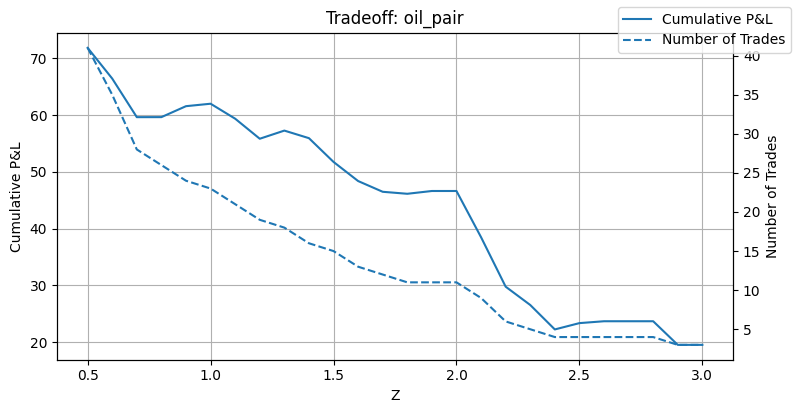

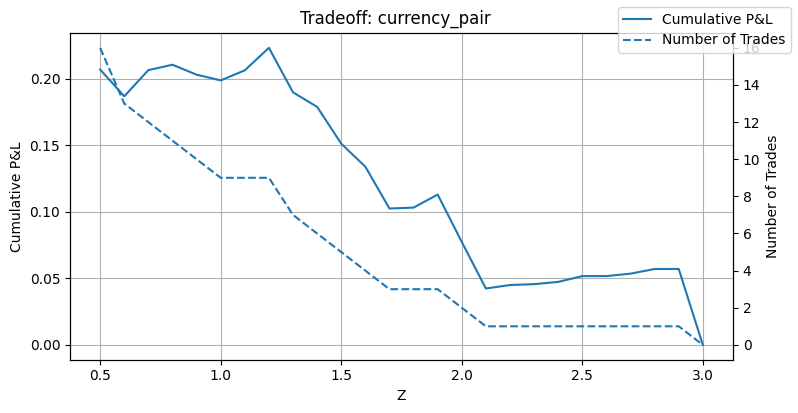

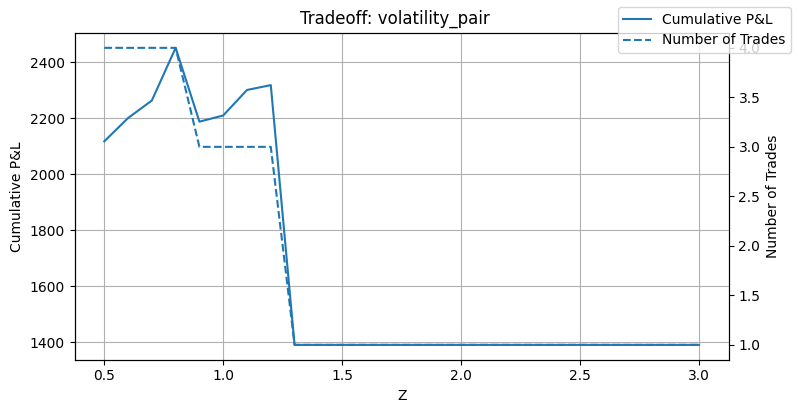

,pair,best_Z,N_trades,cum_PnL,avg_PnL
0,oil_pair,0.50,41.00,71.85,1.75
1,currency_pair,1.20,9.00,0.22,0.02
2,volatility_pair,0.80,4.00,2451.78,612.94


In [11]:
selected = ["oil_pair", "currency_pair", "volatility_pair"]
summary_df, opt_tables = analyze_pairs_nb(
    all_data,
    selected,
    Z_min=0.5,
    Z_max=3.0,
    dZ=0.1,
    cost=0.002
)

summary_df

Oil Pair (WTI vs. Brent): The WTI vs Brent spread csn be driven by physical market factors such regional supply bottlenecks, pipeline outages, and differing quality grades. Also macro drivers like OPEC quotas can impact the supply of WTI/Brent asymetrically. A structural break might occur if pipeline infrastructure is upgraded or if new export policies realign U.S. crude balances which could permanently narrow or widen the spread. Geopolitical events (Libyan civil unrest, U.S. shale booms) can induce regime shifts. These fundamental drivers can pivot the long run equilibrium defined by past price differentials and the signal might then no longer hold.

Currency Pair (AUD/USD vs. CAD/USD) & Volatility Pair (VIX vs. VIXY): The AUD–CAD cross owes its co movement to both being commodity currencies, but central bank divergence e.g. the RBA cutting rates sharply while the BoC remains hawkish can decouple their rates and break the historical cointegration. For VIX vs VIXY structural breaks arise when futures curve dynamics change, a systemic shift in collateral demand or a persistent volatility regime (e.g. prolonged low volatility or crisis spikes) can alter the term structure roll yield that VIXY captures. In both cases, a shifting monetary policy stance or a regime change in risk aversion can turn the once stationary spread into a drifting series.

In this cell, we are performing a rolling, out-of-sample backtest for each of the selected pairs (**oil_pair**, **currency_pair**, **volatility_pair**) using the `run_pair_backtests` function. This function applies a walk-forward cross-validation approach: it splits the time series into multiple train/test windows (with 18 months for training, 6 months for testing, and a 3-month step between splits). For each window, it optimizes the Z-score threshold for trade entry/exit using the training data, then evaluates strategy performance on the unseen test data for several Z values (`z_list`). 

The output, `pair_results`, summarizes key performance metrics (such as Sharpe ratio, average PnL, and trade count) for each pair and each test window, providing a robust assessment of how the mean-reversion strategy would have performed historically under realistic, out-of-sample conditions.

In [12]:
pair_results = run_pair_backtests(
    selected=selected,
    all_data=all_data,
    z_list=[0.5, 1.0, 1.5, 2.0],
    train_months=18,
    test_months=6,
    step_months=3
)

pair_results

{'oil_pair':    train_start   train_end  test_start    test_end  best_z  train_sharpe  \
 0   2020-08-03  2022-02-03  2022-02-03  2022-08-03    0.50          1.73   
 1   2020-11-03  2022-05-03  2022-05-03  2022-11-03    0.50          2.09   
 2   2021-02-03  2022-08-03  2022-08-03  2023-02-03    0.50          1.94   
 3   2021-05-03  2022-11-03  2022-11-03  2023-05-03    0.50          1.76   
 4   2021-08-03  2023-02-03  2023-02-03  2023-08-03    0.50          1.76   
 5   2021-11-03  2023-05-03  2023-05-03  2023-11-03    0.50          1.65   
 6   2022-02-03  2023-08-03  2023-08-03  2024-02-03    0.50          1.74   
 7   2022-05-03  2023-11-03  2023-11-03  2024-05-03    0.50          1.78   
 8   2022-08-03  2024-02-03  2024-02-03  2024-08-03    0.50          1.70   
 9   2022-11-03  2024-05-03  2024-05-03  2024-11-03    1.00          1.69   
 10  2023-02-03  2024-08-03  2024-08-03  2025-02-03    0.50          1.66   
 11  2023-05-03  2024-11-03  2024-11-03  2025-05-03    0.50     

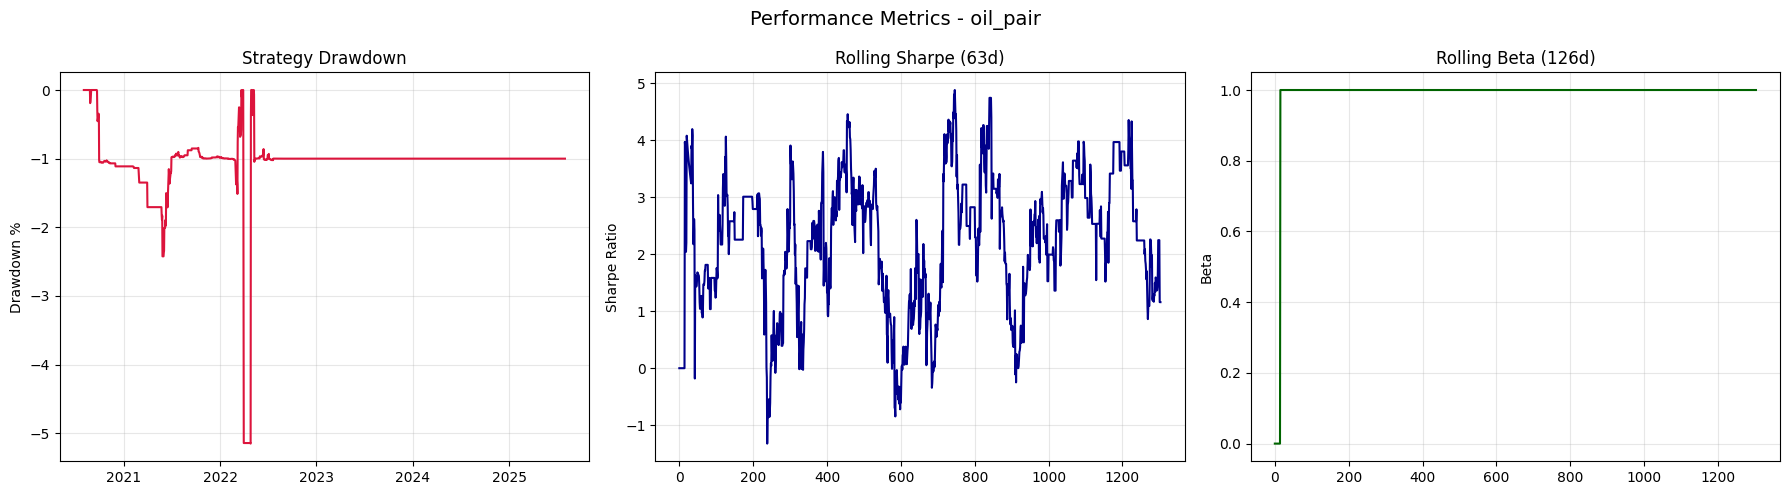

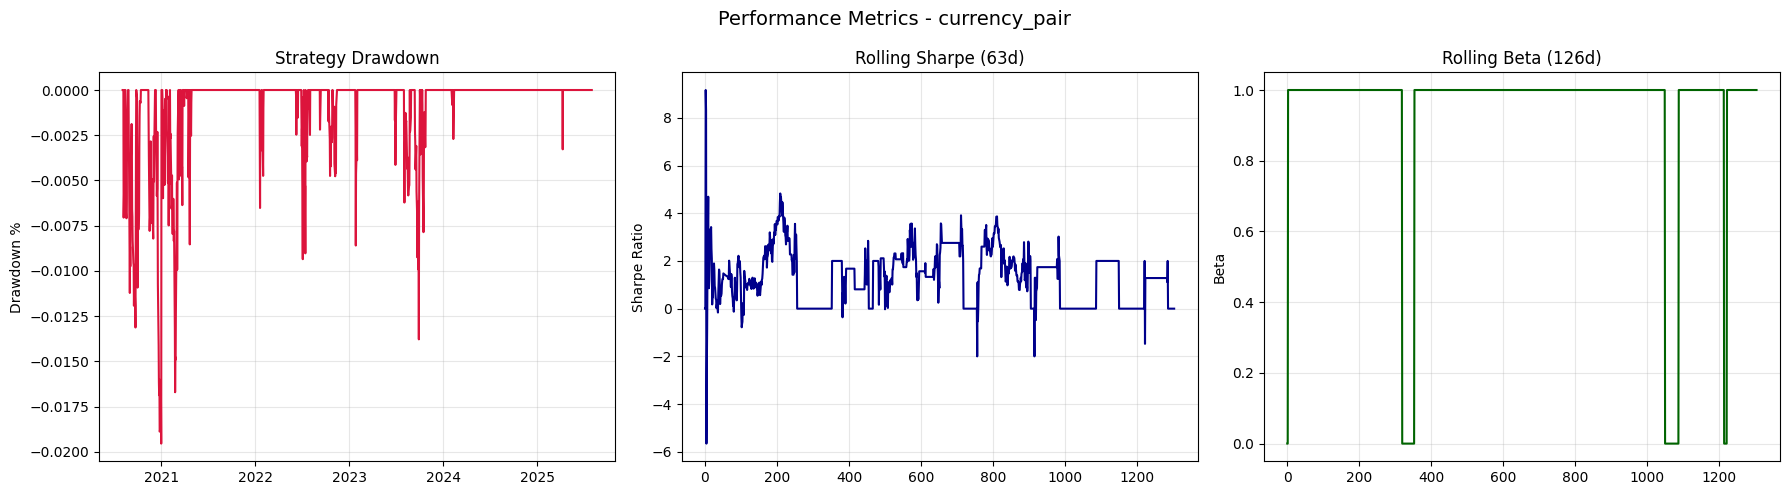

/home/gusta/projects/cqf_final_exam/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


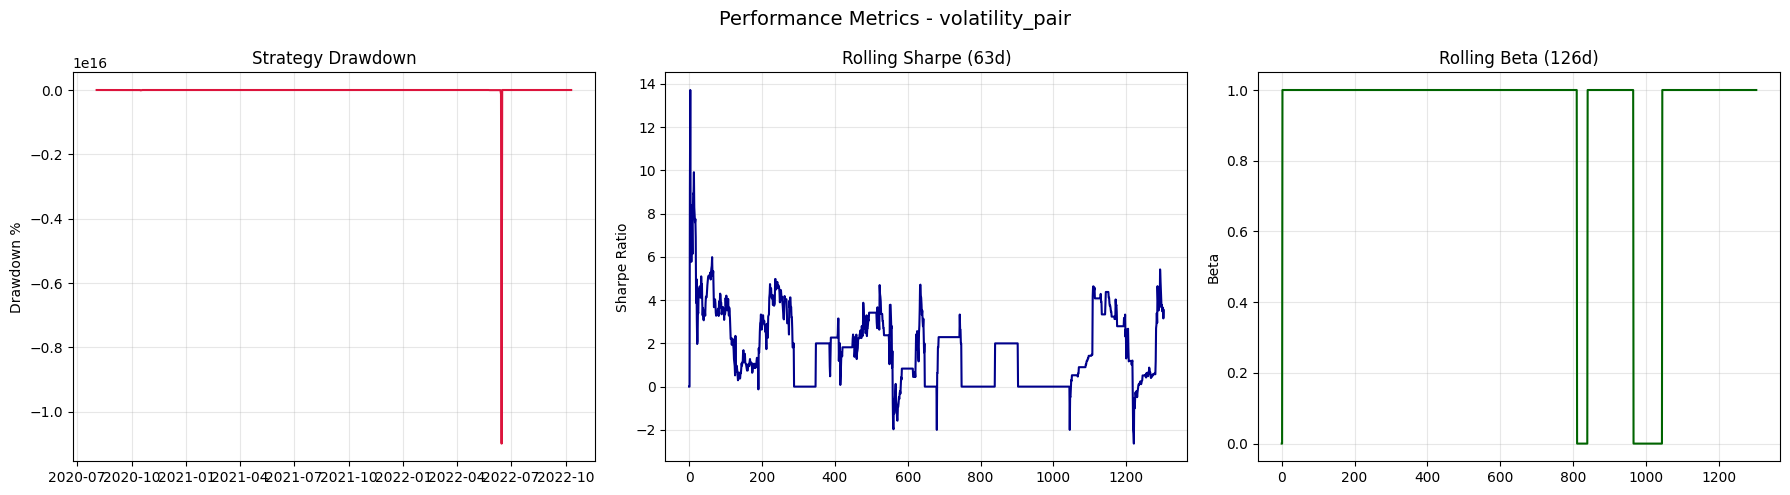

In [13]:
import matplotlib.pyplot as plt

# Generate PnL for all pairs
pair_pnl = generate_pair_pnl(
    all_data=all_data,
    summary_df=summary_df,
    selected=selected
)

for pair_name, pnl in pair_pnl.items():
    returns = pnl.diff().fillna(0)
    plot_performance(returns, sharpe_window=63, beta_window=126, pair_name=pair_name)
    plt.show()